# Goose test page 3 (grid, AOR)

Text(0.5, 1.0, 'Pinkfoot locations on day 300')

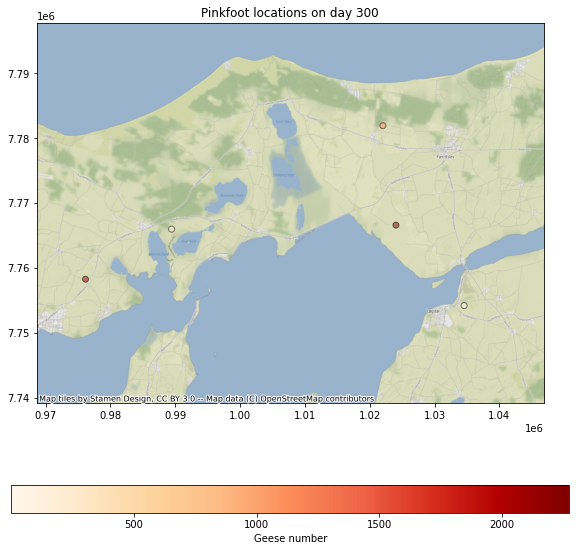

In [1]:
import geopandas as gpd
#import rasterio
import pandas as pd
import datetime as dt
import numpy as np
#import time
#import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import configparser, os, glob
import contextily as ctx
import re
from IPython.display import display, HTML
simulation_start_date = dt.date(2009, 1, 1)# we should check again that this is a right date, probably should be read from somewhere
simulation_start_date_ordinal=dt.date.toordinal(simulation_start_date)
my_dateparser=(lambda x: pd.to_datetime(x,unit='D', origin=simulation_start_date))

# def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
#     xmin, xmax, ymin, ymax = ax.axis()
#     basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
#     ax.imshow(basemap, extent=extent, interpolation='bilinear')
#     # restore original x/y limits
#     ax.axis((xmin, xmax, ymin, ymax))

is_timed = True

species_names = ["barnacle", "greylag", "pinkfoot"]
geese_foods = ['grain', 'grass', 'maize']
if is_timed==True:
    is_timed_str = '_timed'
else:
    is_timed_str = ''
    
data_dir = "rundir/" #"~/CLionProjects/GooseTests/run-directory1/"
#source_dir = "~/CLionProjects/ALMaSS_all"
field_dir ="fielddir"#"~/CLionProjects/GooseTests/ALMaSS_inputs"
additional_dir = "~/CLionProjects/data/"
# let us read the config data, it will be useful afterwards
CONFIG_PATH=data_dir+'TIALMaSSConfig.cfg'
with open(os.path.expanduser(CONFIG_PATH), 'r') as f:
    config_string = '[dummy_section]\n' + f.read()
config = configparser.ConfigParser(strict=False)
config.read_string(config_string)
xy_data=pd.read_csv(data_dir+"GooseXYDump.txt", sep='\t', header=0)
v_out=gpd.read_file(os.path.expanduser(additional_dir+"vejlerne-outline.gpkg"))
v_out_crs=v_out.to_crs(crs = "+proj=utm +zone=32 +ellps=GRS80 +units=m +no_defs")
w, s, e, n =v_out_crs.to_crs(epsg=3857).total_bounds
img, ext=ctx.bounds2img(w, s, e, n, zoom=12)
# define grid size
grid_size = 1000
# Since the map to use is (according to ldalby)
x = 484378
y = 6335161
dimx = 36000
dimy = 24000
# I still do not understand completely why Lars does it, 
#I am rather sure there is some more obvious way to do the following calculation:
xy_data['X_manip'] = np.int_(np.floor(xy_data.X+x)) # Longtitude
xy_data['Y_manip'] = np.int_(np.floor(y-xy_data.Y)) # Latitude
xy_summary=xy_data.groupby(['X_manip', 'Y_manip']).agg(geese_num=('X','count'))

geodata=gpd.GeoDataFrame(xy_summary,geometry=gpd.points_from_xy([i[0] for i in list(xy_summary.index.unique())],[i[1] for i in list(xy_summary.index.unique())]),
                         crs ="+proj=utm +zone=32 +ellps=GRS80 +units=m +no_defs").to_crs(epsg=3857)
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, extent=ext)
geodata.plot(column='geese_num',alpha=0.5, edgecolor='k', cmap='OrRd', ax=ax,legend_kwds={'label': "Geese number", 'orientation': "horizontal"},legend=True)
ctx.add_basemap(ax, zoom=12)
ax.set_title('Pinkfoot locations on day 300')

## Geese AOR

In [2]:
AORfiles_list=glob.glob(os.path.expanduser(data_dir)+'AOR*.txt')
regex=re.compile("(?<=AOR_)(.*?)(?=.txt)")
AOR_dataframe = pd.read_csv(os.path.expanduser(data_dir)+'AOR_Probe.txt', sep='\t', header=0)

for i in AORfiles_list:
    species_name = regex.search(i).group(0)
    if any(species_name in s for s in species_names):
        AOR_data=pd.read_csv(i, sep='\t', header=0)
        AOR_data['Species']=species_name
        AOR_dataframe = pd.concat([AOR_dataframe,AOR_data])
# let us transform the table to what Lars likes it to be using melt:
regex1=re.compile("[0-9]*?$")
AOR_dataframe1=AOR_dataframe.melt(id_vars=['Year', 'Day', 'Species', 'Total_no'], value_vars=[ 'Cells50', 'Cells100', 'Cells200', 'Cells400'], var_name='Cell_size', value_name='Cells')
AOR_dataframe1["Cell_size"]=[regex1.search(s).group(0) for s in AOR_dataframe1["Cell_size"]]
AOR_dataframe2=AOR_dataframe.melt(id_vars=['Year', 'Day', 'Species', 'Total_no'], value_vars=[ 'Occupied50', 'Occupied100', 'Occupied200', 'Occupied400'], var_name='Cell_size', value_name='Occupied')
AOR_dataframe2["Cell_size"]=[regex1.search(s).group(0) for s in AOR_dataframe2["Cell_size"]]
AOR_dataframe_merged= pd.merge(AOR_dataframe1, AOR_dataframe2)
AOR_dataframe_merged['Date']=my_dateparser(np.uint(AOR_dataframe_merged['Day']))
AOR_dataframe_merged['Proportion_occupied'] = AOR_dataframe_merged['Occupied']/AOR_dataframe_merged['Cells']
AOR_dataframe_merged['Mean_Occupied_density'] = AOR_dataframe_merged['Total_no']/AOR_dataframe_merged['Occupied']
print ("Geese AOR table:")
display(AOR_dataframe_merged)

Geese AOR table:


,Year,Day,Species,Total_no,Cell_size,Cells,Occupied,Date,Proportion_occupied,Mean_Occupied_density
0,1,300,greylag,4709,50,345600,233,2009-10-28,0.00067419,20.2103
1,1,300,barnacle,5184,50,345600,29,2009-10-28,8.3912e-05,178.759
2,1,300,pinkfoot,5631,50,345600,7,2009-10-28,2.02546e-05,804.429
3,1,300,greylag,4709,100,86400,233,2009-10-28,0.00269676,20.2103
4,1,300,barnacle,5184,100,86400,29,2009-10-28,0.000335648,178.759
5,1,300,pinkfoot,5631,100,86400,7,2009-10-28,8.10185e-05,804.429
6,1,300,greylag,4709,200,21600,231,2009-10-28,0.0106944,20.3853
7,1,300,barnacle,5184,200,21600,29,2009-10-28,0.00134259,178.759
8,1,300,pinkfoot,5631,200,21600,7,2009-10-28,0.000324074,804.429
9,1,300,greylag,4709,400,5400,217,2009-10-28,0.0401852,21.7005


*The results seem reasonable for me. But maybe we need to change the code, [so the other species (not just pinkfoot) will be dumped (XYdump) and the day of the XY dump should be defined in configuration and not hardcoded.](https://gitlab.com/ChrisTopping/ALMaSS_all/-/issues/67)*<br>
*AOR: according to the paper (Hoeye et al, 2012) the grid size for the individual species should be chosen so that the mean occupied density will be close to 5 individuals. This rule does not apply to any of the grids.*